# Write some code <tag id="special">

Reducing memory useage of large dataframes

In [236]:
import pandas as pd
import numpy as np

In [265]:
# df = pd.DataFrame([np.zeros(5),
#                    np.random.randn(5),
#                    np.ones(5),
#                   ['text']*5,
#                  [1,2,3,'4',5],
#                   [1,2,3,'4',np.nan]]).T

# #extend the df
# df = pd.concat([df for x in range(500000)])

# # reload from file so pandas guesses the datatypes to simulate using real data
# df.to_csv('test.csv',index=False)
raw_df = pd.read_csv('test.csv')
raw_df.head()

,0,1,2,3,4,5
0,0.0,-1.715003,1.0,text,1,1.0
1,0.0,0.222299,1.0,text,2,2.0
2,0.0,-0.121185,1.0,text,3,3.0
3,0.0,-0.480708,1.0,text,4,4.0
4,0.0,0.396265,1.0,text,5,NaN


In [266]:
mem_use(raw_df)

0 float64 : 	19.07 MB
1 float64 : 	19.07 MB
2 float64 : 	19.07 MB
3 object : 	145.44 MB
4 int64 : 	19.07 MB
5 float64 : 	19.07 MB
total memory: 240.80 MB


In [267]:
#DEFINE FUNCTIONS  - see article here https://www.kaggle.com/code/zmey56/using-pandas-with-large-data-sets
def mem_use(df_):
    all_dtype = df_.dtypes
    mem = df_.memory_usage(deep=True)
    for col in df_.columns:
        print(col, all_dtype.loc[col], f": \t{mem.loc[col]/ 1024 ** 2:03.2f} MB")
    return print(f"total memory: {mem.sum()/ 1024 ** 2:03.2f} MB")
    
def reduce_dtypes(df_, allow_categorical:bool=True, **field_max: dict):
    """can give a dictionary for fields where you know the true max value
    even if the data doesnt go up that high in the raw data
    eg. {'column2':5_000_000_000, 'column3':5}
    """
    original_col_order = list(df_.columns)
    
    #integers
    int_types = ["int","int8","int16","int32","int64","uint8","uint16","uint32","uint64"]
    df_int = df_.select_dtypes(include=int_types)
    df_int_new = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_.drop(columns=list(df_int.columns),inplace=True)

    #floats
    float_types = ["float","float16","float32","float64"]
    df_float = df_.select_dtypes(include=float_types)
    df_float_new = df_float.apply(pd.to_numeric, downcast='float')
    df_.drop(columns=list(df_float.columns),inplace=True)
    
    #categories - if 80% duplication or more
    df_obj = df_.select_dtypes(include=['object'])
    desc = df_obj.describe()
    to_cat = list(desc.T[desc.T['unique'] < 0.2 * desc.T['count']].index)
    for cat in to_cat:
        df_obj[cat] = df_obj[cat].astype('category')
    df_.drop(columns=to_cat,inplace=True)
        
    df_ = pd.concat([df_, df_int_new, df_float_new, df_obj], axis=1)[original_col_order]
    return df_

In [268]:
raw_df.dtypes

0    float64
1    float64
2    float64
3     object
4      int64
5    float64
dtype: object

In [271]:
mem_use(raw_df)

total memory: 0.00 MB


/tmp/ipykernel_27/3941114765.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mem = df_.memory_usage(deep=True)


In [270]:
transformed_df = reduce_dtypes(raw_df)
transformed_df.dtypes

0     float32
1     float32
2     float32
3    category
4       uint8
5     float32
dtype: object

In [257]:
mem_use(transformed_df)

0 float32 : 	9.54 MB
1 float32 : 	9.54 MB
2 float32 : 	9.54 MB
3 category : 	2.38 MB
4 uint8 : 	2.38 MB
5 float32 : 	9.54 MB
total memory: 42.92 MB


reduced from 240MB to 42MB. might make a difference for huge datasets.

In [272]:
raw_df = pd.read_csv('test.csv')
raw_df.head()

,0,1,2,3,4,5
0,0.0,-1.715003,1.0,text,1,1.0
1,0.0,0.222299,1.0,text,2,2.0
2,0.0,-0.121185,1.0,text,3,3.0
3,0.0,-0.480708,1.0,text,4,4.0
4,0.0,0.396265,1.0,text,5,NaN


In [273]:
raw_df.to_parquet('raw_df.parquet')
transformed_df.to_parquet('transformed_df.parquet')
# very fast to write

In [274]:
raw_df_parquet = pd.read_parquet('raw_df.parquet')
transformed_df_parquet = pd.read_parquet('transformed_df.parquet')

In [276]:
mem_use(raw_df_parquet)

0 float64 : 	19.07 MB
1 float64 : 	19.07 MB
2 float64 : 	19.07 MB
3 object : 	145.44 MB
4 int64 : 	19.07 MB
5 float64 : 	19.07 MB
total memory: 240.80 MB


In [277]:
mem_use(transformed_df_parquet)

0 float32 : 	9.54 MB
1 float32 : 	9.54 MB
2 float32 : 	9.54 MB
3 category : 	2.38 MB
4 uint8 : 	2.38 MB
5 float32 : 	9.54 MB
total memory: 42.92 MB


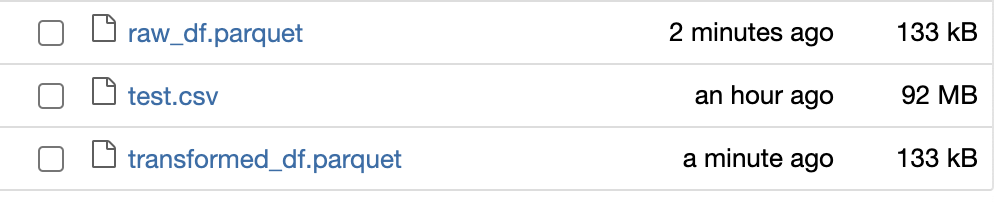

BOTH PARQUET FILES ARE THE SAME SIZE, HOWEVER, PARQUET DOES REMEMBER THE DATATYPES, SO USES LESS MEMORY ON IMPORT!